## WHEN APPROACH

In [1]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("List available databases and tables").config("hive.metastore.uris", "thrift://bialobog:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session

spark.catalog.listDatabases()

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/hadoop-3.2.2/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/opt/apache-hive-2.3.7-bin/lib/log4j-slf4j-impl-2.6.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
2024-02-11 23:34:03,627 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2024-02-11 23:34:06,747 WARN spark.ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


[Database(name='2023_11_01', description='FactSet data snapshot for 2023_11_01', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_01'),
 Database(name='2023_11_02', description='FactSet data snapshot for 2023_11_02', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_02'),
 Database(name='2023_11_03', description='FactSet data snapshot for 2023_11_03', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_03'),
 Database(name='2023_11_14', description='FactSet data snapshot for 2023_11_14', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_14'),
 Database(name='2023_11_19', description='FactSet data snapshot for 2023_11_19', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_19'),
 Database(name='2023_11_22', description='FactSet data snapshot for 2023_11_22', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_22'),
 Database(name='2024_01_25', description='FactSet da

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 39624)
Traceback (most recent call last):
  File "/usr/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/opt/spark/python/pyspark/accumulators.py", line 262, in handle
    poll(accum_updates)
  File "/opt/spark/python/pyspark/accumulators.py", line 235, in poll
    if func():
  File "/opt/spark/python/pyspark/accumulators.py", line 239, in accum_updates
    num_updates = read_int(self.rfile)
  File "/opt/spark/python/pyspark/serializers.py", line 564, in read_int
 

In [2]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql import functions as F

spark.sql("USE 2023_11_02")


DataFrame[]

#### Helper Functions

In [3]:
from pyspark.sql.functions import when
from datetime import datetime, timedelta

def get_all_stocks_df():
    query = f"""SELECT s.ticker_region, s.fsym_id FROM sym_ticker_region s 
                LEFT JOIN FF_SEC_COVERAGE c ON c.fsym_id = s.fsym_id
                LEFT JOIN sym_coverage sc ON sc.fsym_id = s.fsym_id
                WHERE s.ticker_region LIKE "%-US" AND s.ticker_region NOT LIKE '%.%' AND c.CURRENCY = "USD"
                AND (sc.fref_listing_exchange = "NAS" OR sc.fref_listing_exchange = "NYS")"""
    df = spark.sql(query)
    df = df.withColumn("ticker_region", regexp_replace("ticker_region", "-US$", ""))
    return df


def get_not_null_cols(df, table='FF_ADVANCED_DER_AF'):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    query1 = f"""SELECT t.fsym_id AS fsym_id2, a.*
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id
                WHERE a.date > '2000-01-01'
                ORDER BY t.fsym_id, a.date
            """
    #we get all the available dates per stock, so these null values are only within the timeframe available
    q_df = spark.sql(query1)
    q_df = q_df.drop('date', 'adjdate', 'fsym_id2', 'fsym_id')
    num_rows = q_df.count()
    column_types = q_df.dtypes
    good_cols = []
    selected_columns = [F.col(c) for c, c_type in zip(q_df.columns, column_types) if c_type[1] == 'double']
    q_df = q_df.select(selected_columns)
    count_df = q_df.select( [(F.count(F.when(F.isnan(c) | F.col(c).isNull(), c))/num_rows).alias(c) for c in q_df.columns])
    count_dict = count_df.first().asDict()
    filtered_keys = [key for key, value in count_dict.items() if value <= 0.25]
    return filtered_keys
#     for c, c_type in zip(q_df.columns, column_types):
#         if c_type[1] == 'double':
#             null_count = F.sum(F.when(F.isnan(F.col(c)) | F.col(c).isNull(), 1).otherwise(0))
#             null_pct = (null_count / num_rows).alias(f"{c}_null_pct")
#             q_df_agg = q_df.agg(null_pct)
#             actual_pct = q_df_agg.collect()[0][0]
#             if actual_pct < 0.25:
#                 good_cols.append(c)
            
#     return good_cols


def write_features_file(data_list, csv_file_path='features.csv'):
    data_list = [data_list]
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in data_list:
            writer.writerow(row)
    print("Features written: ", data_list[0])



In [4]:
import os

curr_dir = os.getcwd()
main_dir = os.path.dirname(curr_dir)
print(main_dir)

/home/ztewari/Stock-Implosion-Prediction-FYP


In [5]:
from CreateDataset import get_tabular_dataset, get_feature_col_names, get_not_null_cols, get_tabular_dataset_qf
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import when, lit, col
# import pyspark.pandas as ps
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import csv
from sklearn.impute import SimpleImputer

def plot_nulls(df):
    null_counts = df.agg(*[
    (1 - (F.count(c) / F.count('*'))).alias(c + '_nulls') for c in df.columns])
    null_counts_pd = null_counts.toPandas().transpose()
    null_counts_pd.columns = ['null_percentage']

    # Plot the bar chart
    null_counts_pd.plot(kind='bar', legend=False, figsize=(20, 6))
    plt.title('Percentage of Null Values in Each Column')
    plt.ylabel('Percentage of Null Values')
    plt.xlabel('Columns')
    plt.show()
    
def plot_nulls_per_year(df):
    # Extract year from the date_column
    df = df.withColumn('Year', F.year('date'))
    
    # Group by year and sum null values for each column
    nulls_per_year = df.groupBy('Year').agg(*[
        (1 - (F.count(c) / F.count('*'))).alias(c + '_nulls') for c in df.columns
    ]).toPandas()

    # Plot
    nulls_per_year.plot(kind='bar', x='Year', figsize=(20, 6))
    plt.title('Total Null Values per Year')
    plt.ylabel('Total Null Values')
    plt.xlabel('Year')
    plt.show()



def get_df(fn, all_feats=False, imploded_only=False, prediction=False):
    df = get_tabular_dataset(fn, all_feats=all_feats, imploded_only=imploded_only, prediction=prediction, null_thresh=0.2)
    # df = get_tabular_dataset(fn, all_feats=all_feats, imploded_only=imploded_only, prediction=prediction, null_thresh=0.2)

    
    return df

def write_features_file(data_list, csv_file_path='features.csv'):
    data_list = [data_list]
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in data_list:
            writer.writerow(row)
    print("Features written: ", data_list[0])

df = get_df(f'{main_dir}/data/imploded_stocks_dd.csv', all_feats=True, imploded_only=False, prediction=False)


/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
2024-02-11 23:34:34,804 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


['ff_accr_exp', 'ff_assets_com_eq', 'ff_assets_eq', 'ff_assets_gr', 'ff_assets_oth_tot', 'ff_assets_per_emp', 'ff_bps_gr', 'ff_capex_assets', 'ff_capex_ps_cf', 'ff_cash_curr_assets', 'ff_cash_div_cf', 'ff_cash_roce', 'ff_cf_ps_gr', 'ff_cf_sales', 'ff_cogs_sales', 'ff_com_eq_gr', 'ff_com_eq_tcap', 'ff_debt_com_eq', 'ff_debt_entrpr_val', 'ff_debt_eq', 'ff_debt_lt_cf', 'ff_debt_st_x_curr_port', 'ff_dfd_tax_assets_lt', 'ff_dil_adj', 'ff_div_yld', 'ff_div_yld_secs', 'ff_earn_yld', 'ff_ebit_oper_mgn', 'ff_ebit_oper_roa', 'ff_ebitda_oper_mgn', 'ff_eff_int_rate', 'ff_emp_gr', 'ff_entrpr_val_sales', 'ff_eps_basic_gr', 'ff_fix_assets_com_eq', 'ff_for_assets_pct', 'ff_for_sales_pct', 'ff_free_ps_cf', 'ff_gross_cf_debt', 'ff_inc_adj', 'ff_inc_sund', 'ff_inc_tax_curr', 'ff_inc_tax_dfd', 'ff_int_exp_oth', 'ff_intang_oth', 'ff_invest_cap', 'ff_invest_lt', 'ff_invest_st_tot', 'ff_ltd_com_eq', 'ff_ltd_tcap', 'ff_min_int_tcap', 'ff_mkt_val_gr', 'ff_mkt_val_public', 'ff_net_cf_debt', 'ff_net_inc_basic_af

In [6]:
df=df.toPandas()
print(len(df[df['label']==1]))

553


/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

In [7]:
# groups = df.groupby('fsym_id')
# for fsym_id, group_data in groups:
#     if group_data['label'].sum() == 1:
#         print(f"fsym_id: {fsym_id}")
#         print(group_data[['fsym_id', 'date', 'label', 'label2']])

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def correlation_matrix(df):
    # df =df.toPandas()
    print("Converted to Pandas")
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr().abs()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.savefig('corr_matrix_tab.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.7:")
    corr_dict = {}
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.7:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                if corr_mat.columns[i] not in corr_dict.keys():
                    corr_dict[corr_mat.columns[i]] = [corr_mat.columns[j]]
                else:
                    corr_dict[corr_mat.columns[i]].append(corr_mat.columns[j])
                    
    for k,v in corr_dict.items():
        if len(corr_dict[k]) >= 1:
            for col in corr_dict[k]:
                if col in df.columns:
                    df=df.drop(col,axis=1)
    
                

    print(df.columns)
    return df

    
               
df=correlation_matrix(df)
# df=correlation_matrix(df)

Converted to Pandas
Variable pairs with absolute correlation above 0.7:
ff_accr_exp - ff_invest_cap: 0.7196041179112771
ff_accr_exp - ff_sga_oth: 0.7247689654202867
ff_assets_com_eq - ff_assets_eq: 0.9977740313964437
ff_assets_com_eq - ff_debt_com_eq: 0.9986906415089507
ff_assets_com_eq - ff_debt_eq: 0.9976965038670106
ff_assets_com_eq - ff_fix_assets_com_eq: 0.9913763695552309
ff_assets_com_eq - ff_ltd_com_eq: 0.9986322689029365
ff_assets_eq - ff_debt_com_eq: 0.9997593361119921
ff_assets_eq - ff_debt_eq: 0.9954708500773313
ff_assets_eq - ff_fix_assets_com_eq: 0.9910501161676604
ff_assets_eq - ff_ltd_com_eq: 0.9997506467572551
ff_assets_per_emp - ff_sales_per_emp: 0.8009300830648081
ff_capex_ps_cf - ff_free_ps_cf: 0.7939942740034843
ff_capex_ps_cf - ff_oper_ps_net_cf: 0.7808066918006235
ff_capex_ps_cf - ff_sales_ps_gr: 0.8809572217736148
ff_capex_ps_cf - ff_eps_dil_aft_xord: 0.7177994928929655
ff_cash_curr_assets - ff_receiv_curr_assets: 0.7015505203284529
ff_cf_ps_gr - ff_eps_basic_gr

In [9]:
# print(len(df[df['label']==1]))

In [10]:
df.columns

Index(['fsym_id', 'date', 'ff_accr_exp', 'ff_assets_com_eq', 'ff_assets_gr',
       'ff_assets_oth_tot', 'ff_assets_per_emp', 'ff_bps_gr',
       'ff_capex_assets', 'ff_capex_ps_cf', 'ff_cash_curr_assets',
       'ff_cash_div_cf', 'ff_cash_roce', 'ff_cf_ps_gr', 'ff_cf_sales',
       'ff_com_eq_gr', 'ff_com_eq_tcap', 'ff_debt_entrpr_val', 'ff_debt_lt_cf',
       'ff_debt_st_x_curr_port', 'ff_dfd_tax_assets_lt', 'ff_dil_adj',
       'ff_div_yld', 'ff_earn_yld', 'ff_ebit_oper_roa', 'ff_eff_int_rate',
       'ff_emp_gr', 'ff_entrpr_val_sales', 'ff_for_assets_pct',
       'ff_gross_cf_debt', 'ff_inc_adj', 'ff_inc_sund', 'ff_inc_tax_curr',
       'ff_inc_tax_dfd', 'ff_int_exp_oth', 'ff_intang_oth', 'ff_invest_lt',
       'ff_invest_st_tot', 'ff_ltd_tcap', 'ff_min_int_tcap', 'ff_mkt_val_gr',
       'ff_mkt_val_public', 'ff_net_inc_bef_xord_gr', 'ff_net_inc_per_emp',
       'ff_net_mgn_gr', 'ff_non_oper_exp', 'ff_oper_cf_fix_chrg',
       'ff_oper_inc_tcap', 'ff_receiv_turn', 'ff_reinvest_rate

In [11]:
# feats = df.columns[2:-1]
feats = df.columns[2:-1]
df[feats] = df.groupby('fsym_id')[feats].transform(lambda x : x.fillna(method='ffill'))
df[feats] = df.groupby('fsym_id')[feats].transform(lambda x: x.fillna(x.median()))
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year


/opt/jupyterhub/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/jupyterhub/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [12]:
null_values_per_column = df.isnull().sum().tolist()

print(null_values_per_column)

[0, 0, 16892, 467, 181, 282, 4645, 436, 643, 2473, 24548, 680, 1449, 3210, 4648, 369, 69, 1284, 977, 65, 0, 99, 1516, 1302, 14640, 4512, 6327, 5830, 7945, 2658, 2, 5, 344, 379, 53, 3762, 89, 11950, 70, 78, 3512, 5377, 1074, 4654, 5278, 735, 5748, 91, 17596, 1326, 412, 5091, 16, 6483, 10, 9978, 13, 2510, 2400, 0, 0, 0, 1037, 88, 3621, 9998, 0, 0, 0, 0]


In [13]:
rows_with_null_count = df.isnull().any(axis=1).sum()

print(rows_with_null_count)

47257


In [14]:
mask = (df['label'] == 0) & (df.isnull().any(axis=1))

df = df[~mask]

In [15]:
null_rows = df[df.isnull().any(axis=1)]

# Print out the rows with null values
print(null_rows)

         fsym_id       date  ff_accr_exp  ff_assets_com_eq  ff_assets_gr  \
153     B0CXCV-R 2019-12-31     0.695000          7.107744    -21.897343   
280     B15GK7-R 2006-12-31     0.000000               NaN     33.333333   
282     B18QS9-R 2001-12-31    30.938000          2.356519    -79.334596   
786     B3DNJ5-R 2002-09-30     0.011290          1.223800    129.914040   
1200    B5K7NT-R 2015-12-31     1.830000          1.073939    -61.972843   
...          ...        ...          ...               ...           ...   
107743  XJPSRQ-R 2001-04-30     7.104000          1.045029     63.303604   
107747  XJPXMG-R 2014-12-31    15.273000          2.131887    -14.004795   
107949  XKT8J2-R 2002-12-31    22.219000          7.035606     -8.684048   
108078  XLTJNY-R 2018-12-31     1.254853               NaN     12.333180   
108867  XQGHLF-R 2007-12-31    69.509000          2.874843     26.947287   

        ff_assets_oth_tot  ff_assets_per_emp   ff_bps_gr  ff_capex_assets  \
153       

In [16]:
# df[feats] = df.groupby(['year'])[feats].transform(lambda x: x.fillna(x.mean()))
df[feats] = df.groupby(['year'])[feats].transform(lambda x: x.fillna(x[df['label'] == 1].mean()))

/tmp/ipykernel_1521146/3684012704.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[feats] = df.groupby(['year'])[feats].transform(lambda x: x.fillna(x[df['label'] == 1].mean()))
/tmp/ipykernel_1521146/3684012704.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[feats] = df.groupby(['year'])[feats].transform(lambda x: x.fillna(x[df['label'] == 1].mean()))
/tmp/ipykernel_1521146/3684012704.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[feats] = df.groupby(['year'])[feats].transform(lambda x: x.fillna(x[df['label'] == 1].mean()))
/tmp/ipykernel_1521146/3684012704.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[feats] = df.groupby(['year'])[feats].transform(lambda x: x.fillna(x[df['label'] == 1].mean()))
/tmp/ipykernel_1521146/3684012704.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[feats] = df.gro

In [17]:
# df.drop('Implosion_Start_Date', axis=1, inplace=True)

In [18]:
df.head(10)

,fsym_id,date,ff_accr_exp,ff_assets_com_eq,ff_assets_gr,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_capex_ps_cf,...,ff_bk_oper_inc_tot,ff_bk_non_oper_inc,ff_cf_roic,ff_liabs_lease,ff_fcf_yld,ff_compr_inc,GDP,Unemployment_Rate,label,year
10,B01DPB-R,2000-12-31,126.800,2.086523,13.270033,50.4,0.266904,35.733896,7.042196,0.560769,...,-42.400,735.800,41.938200,0.000,2.914500,374.300,0.011395,3.9,0,2000
11,B01DPB-R,2001-12-31,116.900,1.858585,16.344051,49.1,0.287300,32.035135,5.819701,0.546013,...,-26.600,728.000,36.909848,0.000,3.497760,499.000,0.005892,5.7,0,2001
12,B01DPB-R,2002-12-31,192.300,1.577311,27.469544,50.5,0.332927,49.489504,4.136858,0.495114,...,-23.600,964.000,44.535432,0.000,9.566950,611.800,0.007046,6.0,0,2002
13,B01DPB-R,2003-12-31,199.400,1.709800,26.677953,61.1,0.386600,15.966712,5.421193,0.804748,...,-25.600,1024.800,13.348427,0.000,0.445420,330.300,0.017772,5.7,0,2003
14,B01DPB-R,2004-12-31,141.300,1.425937,15.019831,57.2,0.444667,32.876210,4.019865,0.667725,...,-16.100,1080.800,30.238720,0.000,3.443230,524.000,0.018033,5.4,0,2004
15,B01DPB-R,2005-12-31,124.100,1.332923,17.679910,55.3,0.483031,20.934404,4.938370,0.930784,...,38.600,631.800,22.581779,0.000,2.573230,413.900,0.013815,4.9,0,2005
16,B01HWF-R,2000-12-31,4.290,2.461819,430.095902,0.0,0.264231,7.477699,10.733200,0.358729,...,0.241,-21.520,-220.061895,0.360,-1.087850,-5.002,0.011395,3.9,0,2000
17,B01HWF-R,2001-12-31,2.068,1.318465,55.179106,0.0,0.289423,84.402230,3.612006,0.119224,...,0.461,-14.296,-35.429017,0.360,-1.087850,-5.002,0.005892,5.7,0,2001
18,B01HWF-R,2002-12-31,6.409,1.628581,35.568933,0.0,0.329670,13.415219,2.737820,0.133583,...,0.403,-4.519,5.849932,0.058,0.436023,-4.560,0.007046,6.0,0,2002
19,B01HWF-R,2003-12-31,9.316,1.779728,52.811308,0.0,0.299791,20.688538,7.038636,0.424682,...,0.461,-12.463,-20.481951,0.086,-5.318870,-11.887,0.017772,5.7,0,2003


In [19]:
# %%capture
# import warnings
# warnings.filterwarnings("ignore")
import tsfel

def feature_extraction_tsfel(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df = df.set_index('date')

    print("retrieving features...")
    cfg = tsfel.get_features_by_domain("statistical")
    print("features retrieved")
    
    result_dfs = []
    for fsym_id, group_df in df.groupby(['fsym_id', 'year']):
        # Exclude 'fsym_id' column from group_df
        non_zero_cols = group_df.columns[(group_df != 0).any()]
        group_df = group_df[non_zero_cols]

        if not group_df.empty:
            print("not empty")
            # try:
            print(group_df.head())
            X = tsfel.time_series_features_extractor(cfg, group_df.drop(['fsym_id', 'year'], axis=1), verbose=0)
            X['fsym_id'] = group_df['fsym_id'].iloc[0]
            X['year'] = group_df['year'].iloc[0]
            print(X.head())
            result_dfs.append(X)
            # except ValueError:
            #     print("error caught")
            #     continue
    
    final_result = pd.concat(result_dfs, ignore_index=True)
    final_result.reset_index(drop=True, inplace=True)
    return final_result

# df2 = feature_extraction_tsfel(df)

In [20]:
def convert_to_prediction(df):
    df_temp = spark.createDataFrame(df)
    ws = Window.partitionBy('fsym_id').orderBy(F.col('date').desc())
    df_temp = df_temp.withColumn('label', F.lag(F.col('label')).over(ws))
    df_temp= df_temp.filter(F.col('label').isNotNull())
    return df_temp.toPandas()

# df = convert_to_prediction(df)

In [21]:
print(len(df))

62036


In [22]:
rows_with_null = df[df.isnull().any(axis=1)]
print(rows_with_null)

Empty DataFrame
Columns: [fsym_id, date, ff_accr_exp, ff_assets_com_eq, ff_assets_gr, ff_assets_oth_tot, ff_assets_per_emp, ff_bps_gr, ff_capex_assets, ff_capex_ps_cf, ff_cash_curr_assets, ff_cash_div_cf, ff_cash_roce, ff_cf_ps_gr, ff_cf_sales, ff_com_eq_gr, ff_com_eq_tcap, ff_debt_entrpr_val, ff_debt_lt_cf, ff_debt_st_x_curr_port, ff_dfd_tax_assets_lt, ff_dil_adj, ff_div_yld, ff_earn_yld, ff_ebit_oper_roa, ff_eff_int_rate, ff_emp_gr, ff_entrpr_val_sales, ff_for_assets_pct, ff_gross_cf_debt, ff_inc_adj, ff_inc_sund, ff_inc_tax_curr, ff_inc_tax_dfd, ff_int_exp_oth, ff_intang_oth, ff_invest_lt, ff_invest_st_tot, ff_ltd_tcap, ff_min_int_tcap, ff_mkt_val_gr, ff_mkt_val_public, ff_net_inc_bef_xord_gr, ff_net_inc_per_emp, ff_net_mgn_gr, ff_non_oper_exp, ff_oper_cf_fix_chrg, ff_oper_inc_tcap, ff_receiv_turn, ff_reinvest_rate, ff_roic, ff_shs_float, ff_tcap_assets, ff_ut_non_oper_inc_oth, ff_ut_operation_exp, ff_wkcap, ff_xord, ff_std_debt, ff_tang_assets_debt, ff_bk_oper_inc_oth, ff_bk_oper_i

In [23]:
df.isnull().sum()

fsym_id              0
date                 0
ff_accr_exp          0
ff_assets_com_eq     0
ff_assets_gr         0
                    ..
ff_compr_inc         0
GDP                  0
Unemployment_Rate    0
label                0
year                 0
Length: 70, dtype: int64

In [24]:
# df3 = df.drop(['ff_cf_sales', 'ff_oper_ps_net_cf', 'ff_invest_st_tot', 'ff_ebit_oper_roa', 'ff_for_assets_pct' ], axis=1)
# print(len(df3))
# df4 = df3.dropna()
# print(len(df4))

In [25]:
print(len(df))
print(len(df[df['label']==1]))


62036
553


In [26]:
# df = df.drop(['ff_cf_sales', 'ff_oper_ps_net_cf', 'ff_invest_st_tot', 'ff_ebit_oper_roa', 'ff_for_assets_pct'  ], axis=1)

In [27]:
df = df.drop('year', axis=1)

In [28]:
# df['date'] = pd.to_datetime(df['date'])
# df['year'] = df['date'].dt.year
# avg_per_year = df.groupby(df['year']).mean()
# avg_per_year.head()

In [29]:
df.head()

,fsym_id,date,ff_accr_exp,ff_assets_com_eq,ff_assets_gr,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_capex_ps_cf,...,ff_bk_oper_inc_oth,ff_bk_oper_inc_tot,ff_bk_non_oper_inc,ff_cf_roic,ff_liabs_lease,ff_fcf_yld,ff_compr_inc,GDP,Unemployment_Rate,label
10,B01DPB-R,2000-12-31,126.8,2.086523,13.270033,50.4,0.266904,35.733896,7.042196,0.560769,...,-50.5,-42.4,735.8,41.938200,0.0,2.91450,374.3,0.011395,3.9,0
11,B01DPB-R,2001-12-31,116.9,1.858585,16.344051,49.1,0.287300,32.035135,5.819701,0.546013,...,-41.7,-26.6,728.0,36.909848,0.0,3.49776,499.0,0.005892,5.7,0
12,B01DPB-R,2002-12-31,192.3,1.577311,27.469544,50.5,0.332927,49.489504,4.136858,0.495114,...,-54.3,-23.6,964.0,44.535432,0.0,9.56695,611.8,0.007046,6.0,0
13,B01DPB-R,2003-12-31,199.4,1.709800,26.677953,61.1,0.386600,15.966712,5.421193,0.804748,...,-63.9,-25.6,1024.8,13.348427,0.0,0.44542,330.3,0.017772,5.7,0
14,B01DPB-R,2004-12-31,141.3,1.425937,15.019831,57.2,0.444667,32.876210,4.019865,0.667725,...,-50.0,-16.1,1080.8,30.238720,0.0,3.44323,524.0,0.018033,5.4,0


In [30]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

In [31]:
df.head()

,fsym_id,ff_accr_exp,ff_assets_com_eq,ff_assets_gr,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_capex_ps_cf,ff_cash_curr_assets,...,ff_bk_oper_inc_oth,ff_bk_oper_inc_tot,ff_bk_non_oper_inc,ff_cf_roic,ff_liabs_lease,ff_fcf_yld,ff_compr_inc,GDP,Unemployment_Rate,label
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,H67MJ3-R,5.093000,1.525212,21.486620,0.712,0.042481,19.349886,12.845357,0.321223,1.375626,...,0.0,0.0,0.000,6.998421,0.000,-5.841260,8.6600,0.011395,3.9,0
2000-01-31,GSXP1N-R,6.019841,1.194269,19.423268,0.000,0.184405,17.212545,2.732302,0.067250,70.773903,...,0.0,0.0,0.000,-23.401890,0.000,-1.583860,22.2000,0.011395,3.9,0
2000-01-31,X6G60N-R,14.573000,1.896771,3.150966,0.000,0.070743,2.905707,8.163560,0.279822,1.950406,...,0.0,0.0,0.000,13.425469,0.000,0.392877,82.7475,0.011395,3.9,0
2000-01-31,D4ZNNX-R,260.920000,4.068287,7.251806,79.474,0.430686,2.524056,1.877362,1.323221,0.885946,...,0.0,0.0,200.754,-2.958117,8.476,-7.485630,127.5010,0.011395,3.9,0
2000-01-31,M1GB1F-R,540.124000,2.212405,-5.843787,62.546,0.087246,9.856730,8.808232,2.946459,1.032376,...,0.0,0.0,365.447,5.058365,155.050,-11.034700,189.6430,0.011395,3.9,0


Converted to Pandas
{0: 0.5044971780817462, 1: 56.09041591320072}
Estimate: 111.181
 30%|███       | 30/100 [01:25<03:18,  2.83s/trial, best loss: -0.32459552906272165]


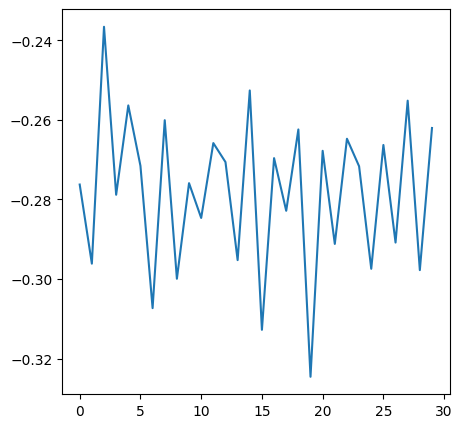

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15374
           1       0.36      0.19      0.24       135

    accuracy                           0.99     15509
   macro avg       0.68      0.59      0.62     15509
weighted avg       0.99      0.99      0.99     15509

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15405
           1       0.36      0.34      0.35       104

    accuracy                           0.99     15509
   macro avg       0.68      0.67      0.67     15509
weighted avg       0.99      0.99      0.99     15509

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15347
           1       0.45      0.33      0.38       162

    accuracy                           0.99     15509
   macro avg       0.72      0.66      0.69     15509
weighted avg       0.99      0.99      0.99     15509

              preci

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from hyperopt import fmin, tpe, hp
from sklearn import tree
import shap
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from collections import Counter
from hyperopt.early_stop import no_progress_loss
from functools import reduce

def feature_importances(model, features):
    feature_importances = model.feature_importances_

    # print("Feature Importances:")
    # for feature, importance in zip(features, feature_importances):
    #     print(f"{feature}: {importance}")

    sorted_idx = np.argsort(feature_importances)
    sorted_features = [features[i] for i in sorted_idx]
    
    half_len = (len(sorted_idx) // 4 ) * 3 # Calculate the index for the middle point

    # Select the lowest 50% of features
    selected_features = [features[i] for i in sorted_idx[:half_len]]

    plt.figure(figsize=(20, 6))
    plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
    plt.xticks(range(len(feature_importances)), sorted_features, rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.title("Feature Importances")
    plt.show()
    return selected_features

def model_testing(df, classifier):
    seed = 42
    print("Converted to Pandas")
    exclude_columns = ['fsym_id', 'label']
    X_train = df.drop(exclude_columns, axis=1)
    y_train = df['label']
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    print(class_weight_dict)
    
    if classifier == 'LogisticRegression':
        param_space = {
            'C': hp.uniform('C', 0.01, 1.0) }
        classifier_instance = LogisticRegression(class_weight = class_weight_dict, solver='sag', seed=42)
        scaler = StandardScaler()
        feats = X_train.columns
        X_train[feats] = scaler.fit_transform(X_train[feats])
        
    elif classifier == 'RandomForest':
        param_space = { 
            'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
            'max_depth': hp.quniform('max_depth', 5, 20, 1)
        }
        classifier_instance = RandomForestClassifier(class_weight = class_weight_dict, random_state=42)
    elif classifier == 'GBT':
        param_space = { 'n_estimators':hp.uniform('n_estimators',100,500),
           'max_depth':hp.quniform('max_depth',5,20,1),
           'min_samples_leaf':hp.quniform('min_samples_leaf',1,5,1),
           'min_samples_split':hp.quniform('min_samples_split',2,6,1)}
        classifier_instance = GradientBoostingClassifier()
    elif classifier == 'XGB':
        param_space = { 'n_estimators':hp.quniform('n_estimators',100,500,1),
                        'max_depth':hp.quniform('max_depth',5,20,1),
                       'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
                       'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
                        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
                        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05)
                      }
        counter = Counter(y_train)
        # estimate scale_pos_weight value
        estimate = counter[0] / counter[1]
        print('Estimate: %.3f' % estimate)
        
        classifier_instance = xgb.XGBClassifier(scale_pos_weight=estimate)
    else:
        raise ValueError("Unsupported classifier")
        
    tscv = TimeSeriesSplit(n_splits=3)
    
    def set_params(classifier, params):
        if classifier == 'RandomForest':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        elif classifier == 'GBT':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            params['min_samples_leaf'] = int(params['min_samples_leaf'])
            params['min_samples_split'] = int(params['min_samples_split'])
            return params
        elif classifier == 'XGB':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        
        else:
            return params
    
    obj_scores = []
        
    def objective(params):
        params = set_params(classifier, params)
        classifier_instance.set_params(**params)
        
        scores = cross_val_score(classifier_instance, X_train, y_train, cv=tscv, scoring='f1')
        score = -scores.mean()
        obj_scores.append(score)
        return score

    def report_average(*args):
        report_list = list()
        for report in args:
            splited = [' '.join(x.split()) for x in report.split('\n\n')]
            header = [x for x in splited[0].split(' ')]
            data = np.array(splited[1].split(' ')).reshape(-1, len(header) + 1)
            data = np.delete(data, 0, 1).astype(float)
            rest = splited[2].split(' ')
            accuarcy =np.array([0, 0, rest[1], rest[2]]).astype(float).reshape(-1, len(header))
            macro_avg = np.array([rest[5:9]]).astype(float).reshape(-1, len(header))
            weighted_avg = np.array([rest[11:]]).astype(float).reshape(-1, len(header))
            #avg_total = np.array([x for x in avg]).astype(float).reshape(-1, len(header))
            df = pd.DataFrame(np.concatenate((data, accuarcy,macro_avg,weighted_avg)), columns=header)
            report_list.append(df)
        res = reduce(lambda x, y: x.add(y, fill_value=0), report_list) / len(report_list)
        res.to_csv(f'when_{classifier}_results.csv')
        return res.rename(index={res.index[-3]: 'accuracy',res.index[-2]: 'macro_avg',res.index[-1]: 'weighted_avg'})
    
    
#     initial_model = classifier_instance
#     initial_model = initial_model.fit(X_train, y_train)
#     initial_preds = pd.DataFrame()
#     print("INITIAL: ")
#     initial_preds['prediction'] = initial_model.predict(X_test)
#     initial_preds['label'] = y_test
#     confusion_matrix_pandas(initial_preds)
    
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=100, early_stop_fn=no_progress_loss(10))
    
    best_params = set_params(classifier, best_params)
    classifier_instance.set_params(**best_params)
    i = 0
    all_reports = []
    plt.figure(figsize=(5,5))
    plt.plot(obj_scores)
    plt.show()
    
    
    for train_index, test_index in tscv.split(X_train):
        x_train, x_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        Y_train, Y_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        classifier_instance.fit(x_train, Y_train)
        
        preds = classifier_instance.predict(x_test)
        report = classification_report(Y_test, preds)
        print(report)
        all_reports.append(report)
        # cm = confusion_matrix(Y_test, preds, labels=classifier_instance.classes_)
        # plt.figure(figsize=(8, 6))
        # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
        # plt.xlabel("Predicted")
        # plt.ylabel("Actual")
        # plt.title("Confusion Matrix")
        # plt.show()
        # final_recall = recall_score(Y_test, preds, pos_label=1)
        # return recall_minority_class
    # return final_recall
    final_report = report_average(*all_reports)
    print(final_report)
    # print("MCC: ", matthews_corrcoef(true, preds))
    final_report.to_csv(f'report_{classifier}_pred')
        # f.write(f"\n\nMatthews Correlation Coefficient: {matthews_corrcoef(true, preds)}")

    return classifier_instance, X_train.columns.tolist(), X_train


model, feats, X_train = model_testing(df, 'XGB')

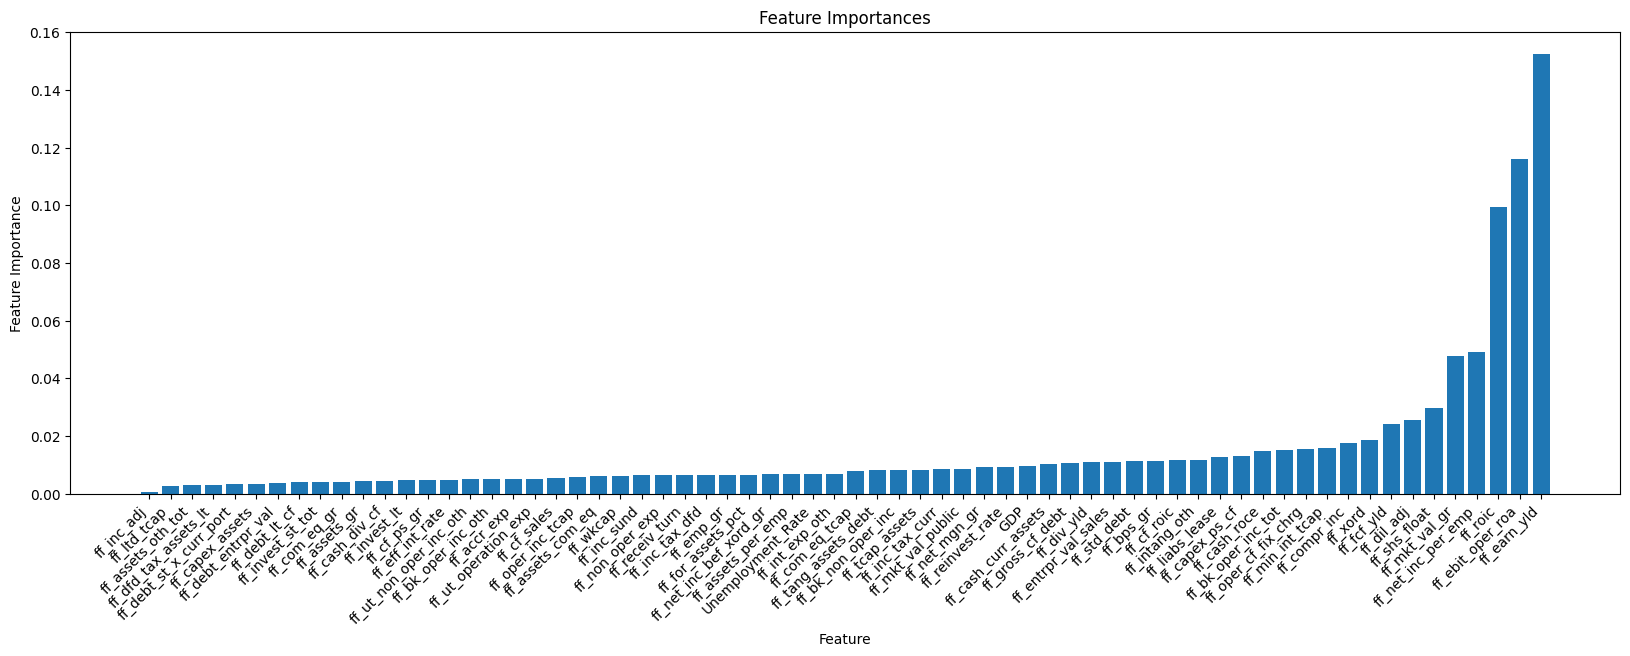

In [33]:
feats_to_drop = feature_importances(model,feats)
# print(feats_to_drop)
# df2 = df.drop(*feats_to_drop)
# model2, feats2, X_train2 = model_testing(df2, 'XGB')

In [34]:
_ = feature_importances(model2,feats2)

NameError: name 'model2' is not defined

{0: 0.5053002856211781, 1: 47.66726943942134}
40994 411 11726 142
0.010127393243476333
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                1600      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1617 (6.32 KB)
Trainable params: 1617 (6.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
367/367 [==============================] - 1s 2ms/step - loss: 0.4288 - cross entropy: 0.4288 - Brier score: 0.0884 - tp: 85.0000 - fp: 1270.0000 - tn: 10314.0000 - fn: 57.0000 - accuracy: 0.8868 

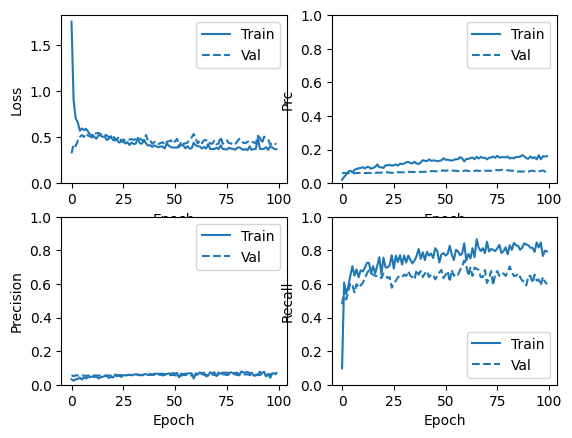

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

# Generate some dummy time series data


# Define the number of folds for cross-validation

def plot_model_performance(mdl, loss, metric):
    x = pd.DataFrame(mdl.history).reset_index()
    x = pd.melt(x, id_vars='index')
    x['validation'] = (x['variable'].str[:4] == 'val_').replace({True:'validation',False:'training'})
    x['loss'] = (x['variable'].str[-4:] == 'loss').replace({True:loss,False:metric})
    g = sns.FacetGrid(x, col='loss', hue='validation',sharey=False)
    g.map(sns.lineplot, 'index','value')
    g.add_legend()
    return g

def plot_metrics(history):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':#
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
        
    
def plot_loss(history, label, n):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
  # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

def nn_training(df):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)

    seed = 42
    exclude_columns = ['fsym_id', 'label']
    X = df.drop(exclude_columns, axis=1)
    y = df['label']

    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weight_dict = dict(enumerate(class_weights))
    print(class_weight_dict)
    
    space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
    'batch_size': hp.choice('batch_size', [16, 32, 64]),
    'num_layers': hp.choice('num_layers', [1, 2, 3]),
    'num_neurons': hp.choice('num_neurons', [64, 128, 256]),
    'activation': hp.choice('activation', ['relu', 'sigmoid']),
    'dropout_rate': hp.uniform('dropout_rate', 0, 0.5)
    }
    
    METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]

    
    def make_model(train_features, metrics=METRICS, output_bias=None):
        if output_bias is not None:
            output_bias = tf.keras.initializers.Constant(output_bias)
            
        model = keras.Sequential([
              keras.layers.Dense(
                  16, activation='relu',
                  input_shape=(train_features.shape[-1],)),
              keras.layers.Dropout(0.5),
              keras.layers.Dense(1, activation='sigmoid',
                                 bias_initializer=output_bias),
          ])
   
        
        model.compile(
              optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=metrics)
        return model
    
    def get_preds(model, feats, truth):
        predictions = model.predict(feats, batch_size = 2048)
        print(predictions)
        for i in range(len(predictions)):
            predictions[i] = 1 if predictions[i] >= 0.5 else 0
        print(classification_report(truth, predictions))
    
    
    
#     model = tf.keras.Sequential([
#         tf.keras.layers.Flatten(input_shape=(X.shape[1],)),
#         tf.keras.layers.Dense(64, activation='relu'),
#         tf.keras.layers.Dense(32, activation='relu'),  # Additional Dense layer
#         tf.keras.layers.Dropout(0.5),  # Dropout layer for regularization
#         tf.keras.layers.Dense(16, activation='relu'),  # Another Dense layer
#         tf.keras.layers.Dense(1, activation='sigmoid')
#     ])
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    split_date = '2018-12-31'
    train_index = X.index < split_date
    test_index = X.index >= split_date


    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

    
    print(len(y_train), len(y_train[y_train==1]), len(y_test), len(y_test[y_test==1]))

    scaler=StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    

    pos = len(y_train[y_train==1])
    neg = len(y_train[y_train==0])
    print(pos/neg)
    initial_bias = np.log([pos/neg])

    model = make_model(X_train, output_bias=initial_bias)
    print(model.summary())

    fit_model = model.fit(X_train, y_train, epochs=100, batch_size=2048, validation_data = (X_test, y_test), class_weight = class_weight_dict, 
                        
                         verbose=0)
    # plot_model_performance(fit_model, 'bin_cross_entropy', 'accuracy')
    plot_metrics(fit_model)
    # plot_loss(fit_model, "Train Loss", 0)

    results = model.evaluate(X_test, y_test)
    print(f'Test loss: {results[0]}')

    # Make predictions on new data
    get_preds(model, X_train, y_train)
    get_preds(model, X_test, y_test)
        

#     cm = confusion_matrix(y_test, predictions)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
#     plt.title(f'Confusion Matrix')
#     plt.xlabel('Predicted')
#     plt.ylabel('Actual')
#     plt.show()


    
# nn_training(df)

In [28]:
from hyperopt import hp, fmin, tpe, Trials
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import matthews_corrcoef, f1_score

# Define the search space for hyperparameters

def hyperopt_nn(df):
    exclude_columns = ['fsym_id', 'label']
    X = df.drop(exclude_columns, axis=1)
    y = df['label']
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weight_dict = dict(enumerate(class_weights))
    print(class_weight_dict)
    
    space = {
        'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
        'batch_size': hp.choice('batch_size', [1024, 2048, 4096]),
        'num_layers': hp.choice('num_layers', [2, 3, 4]),
        'num_neurons': hp.choice('num_neurons', [128, 256, 512]),
        'dropout_rate': hp.uniform('dropout_rate', 0, 0.5)
    }
    
    split_date = '2018-12-31'
    train_index = X.index < split_date
    test_index = X.index >= split_date


    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    scaler=StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    print(len(X_train)/len(X))
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

    # Objective function to minimize
    def train_with_params(params):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)))

        for _ in range(params['num_layers']):
            model.add(tf.keras.layers.Dense(params['num_neurons'], activation='relu'))
            model.add(tf.keras.layers.Dropout(params['dropout_rate']))

        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
        model.compile(optimizer=optimizer, loss='binary_crossentropy')

        hist = model.fit(X_train, y_train, batch_size=params['batch_size'], epochs=10, class_weight = class_weight_dict, callbacks = [early_stopping], verbose=0)
        preds = model.predict(X_val, batch_size=params['batch_size'], verbose=0 )
        for i in range(len(preds)):
            preds[i] = 1 if preds[i] >= 0.5 else 0
            
        metric = f1_score(y_val, preds)
        return model, metric
    
    
    def objective(params):
        model, metric = train_with_params(params)
        return -metric



    # Run hyperparameter optimization
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials, early_stop_fn=no_progress_loss(10))
    
    activation_map = {0: 'relu', 1: 'sigmoid'}
    best_hyperparams = {
        'learning_rate': best['learning_rate'],
        'batch_size': [1024, 2048, 4096][best['batch_size']],
        'num_layers': [2, 3, 4][best['num_layers']],
        'num_neurons': [128, 256, 512][best['num_neurons']],
        'dropout_rate': best['dropout_rate']
    }

    print("Best hyperparameters:", best_hyperparams)
    best_model, best_metric = train_with_params(best_hyperparams)
    print(f'Best metric: {best_metric}')
    preds = best_model.predict(X_val, batch_size = best_hyperparams['batch_size'])
    print(preds)
    for i in range(len(preds)):
        preds[i] = 1 if preds[i] >= 0.5 else 0
    print(classification_report(y_val, preds))
    
# hyperopt_nn(df)


{0: 0.5053002856211781, 1: 47.66726943942134}
0.7775796661608497
 34%|███▍      | 17/50 [00:50<01:37,  2.95s/trial, best loss: -0.09411764705882353]
Best hyperparameters: {'learning_rate': 0.04506274524639494, 'batch_size': 4096, 'num_layers': 3, 'num_neurons': 256, 'dropout_rate': 0.30816929049268293}
Best metric: 0.09986130374479889
3/3 [==============================] - 0s 4ms/step
[[0.00000000e+00]
 [2.34954491e-01]
 [1.44408703e-01]
 ...
 [2.34954491e-01]
 [1.29752635e-08]
 [1.86830088e-01]]
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     11584
           1       0.06      0.51      0.10       142

    accuracy                           0.89     11726
   macro avg       0.52      0.70      0.52     11726
weighted avg       0.98      0.89      0.93     11726



In [50]:

def nn_prepare_seqs(df):
    # print(df.columns)
    print("Number of records: ", df.count())
    df = df.filter(reduce(lambda acc, column: acc & (F.size(col(column)) == 22), df.columns[1:-1], F.lit(True)))
    print("Number of records: ", df.count())
    features = df.columns[1:-1]
    print(features)
    label_col = 'label'

    def convert_to_np_array(row):
        seq_feats = row.seq_feats
        label = row.label
        feat_length = len(seq_feats[0])
        date_length = len(seq_feats[0][0])
        seq_array = np.zeros((feat_length, date_length))
        for i, sublist in enumerate(seq_feats[0]):
            seq_array[i, :] = np.array(sublist)
        seq_array = seq_array.T
        return (seq_array, label)
    
    # train_seqs_rdd = grouped_data.rdd.map(convert_to_np_array)
    train_df, test_df = t_t_split(df)
    
    # train_seqs = []
    # for stock_id, group in df.groupby('fsym_id'):
    #     seq_feats = group[features]
    #     label = group['label']
    #     feat_length = len(seq_feats.iloc[0])
    #     date_length = len(seq_feats.iloc[0,0])
    #     seq_array = np.zeros((feat_length, date_length))
    #     for i, sublist in enumerate(seq_feats.columns):
    #         seq_array[i, :] = np.array(seq_feats[sublist].iloc[0])
    #     seq_array = seq_array.T
    #     train_seqs.append((seq_array, label))
        
        
    # df= df.toPandas()
    # print(df.head())
    # features = df.columns[1:-1]
    # list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
    # df = df.toPandas()
    
    
    
    # for f in features:
    #     df = df.withColumn(f, list_to_vector_udf(f))
    # train_df, test_df = train_test_split(df)
    train_df = train_df.toPandas()
    test_df = test_df.toPandas()
    
    train_seqs = []
    for stock_id, group in train_df.groupby('fsym_id'):
        seq_feats = group[features]
        label = group['label']
        feat_length = len(seq_feats.iloc[0])
        date_length = len(seq_feats.iloc[0,0])
        seq_array = np.zeros((feat_length, date_length))
        for i, sublist in enumerate(seq_feats.columns):
            seq_array[i, :] = np.array(seq_feats[sublist].iloc[0])
        seq_array = seq_array.T
        train_seqs.append((seq_array, label))
        
    test_seqs = []
    for stock_id, group in test_df.groupby('fsym_id'):
        seq_feats = group[features]
        label = group['label']
        feat_length = len(seq_feats.iloc[0])
        date_length = len(seq_feats.iloc[0,0])
        seq_array = np.zeros((feat_length, date_length))
        for i, sublist in enumerate(seq_feats.columns):
            seq_array[i, :] = np.array(seq_feats[sublist].iloc[0])
        seq_array = seq_array.T
        test_seqs.append((seq_array, label))
    
    return train_seqs, test_seqs


# df2 = spark.createDataFrame(df)
# nn_prepare_seqs(df2)

In [ ]:
from sklearn.ensemble import IsolationForest

def anomaly_det(df):
    
    tscv = TimeSeriesSplit(n_splits=5)
    seed = 42
    df=df.toPandas()
    print("Converted to Pandas")
    exclude_columns = ['fsym_id']
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    X_train = df.drop(exclude_columns, axis=1)
    Y_train = df['label']
    
    features = X_train.columns[:-1]
    print(len(features))
    
    for train_index, test_index in tscv.split(X_train):
        x_train, x_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        y_train, y_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

        num_pos = len(y_train[y_train == 1])
        print(num_pos/len(y_train))
        isol_for = IsolationForest(contamination=num_pos/len(y_train), random_state=42)

        isol_for.fit(x_train[features])

        train_df = x_train.copy()  # Create a copy of the training set for results
        test_df = x_test.copy()    # Create a copy of the test set for results

        train_df['anomaly_scores'] = isol_for.decision_function(train_df[features])
        train_df['anomaly'] = isol_for.predict(train_df[features])
        train_df['preds'] = np.where(train_df['anomaly'] == 1, 0, 1)

        test_df['anomaly_scores'] = isol_for.decision_function(test_df[features])
        test_df['anomaly'] = isol_for.predict(test_df[features])
        test_df['preds'] = np.where(test_df['anomaly'] == 1, 0, 1)

        print(f"Classification Report: ")
        print(classification_report(y_test, test_df['preds']))
        # cm = confusion_matrix(y_test, test_df['preds'])
        # plt.figure(figsize=(8, 6))
        # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
        # plt.xlabel("Predicted")
        # plt.ylabel("Actual")
        # plt.title("Confusion Matrix")
        # plt.show()
        
   

    
    
    
# anomaly_det(df2)

In [ ]:
def shapley(model, train, test):
    # exclude_columns = ['fsym_id',  'label']
    # X_train = train.drop(exclude_columns, axis=1)
    # X_test = test.drop(exclude_columns, axis=1)
    explainer = shap.Explainer(model)
    shap_values = explainer(train)
    shap.initjs()
    print(shap_values.shape)
    shap.plots.waterfall(shap_values[0])
    
shapley(model2, X_train2, None)

In [ ]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


def boruta_fs(train_df, model_name): #HOW DOES BORUTA ACC WORK?
    train_df = train_df.toPandas()
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
    
    if model_name == 'rf':
        model = RandomForestClassifier()
    else:
        model = GradientBoostingClassifier
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=1, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 5:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features

rf_feats = boruta_fs(df, 'rf')
# gbt_feats = boruta_fs(df, 'gbt')

### Investigating metrics that changed the most before and after implosions

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import when, lit, col
# import pyspark.pandas as ps
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import csv


def pct_change_df(df, big_string, table):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    
    query1 = f"""
                SELECT t.fsym_id, t.Implosion_Start_Date, b.date, {big_string}
                FROM temp_table t
                LEFT JOIN sym_ticker_region s ON s.fsym_id = t.fsym_id
                LEFT JOIN {table} a ON s.fsym_id = a.fsym_id AND  YEAR(a.date) = YEAR(t.Implosion_Start_Date)
                LEFT JOIN {table} b ON s.fsym_id = b.fsym_id AND  YEAR(b.date) = YEAR(t.Implosion_Start_Date)-1
                ORDER BY t.fsym_id
            """
    df1 = spark.sql(query1)
    #print(df1.show())
    df1 = df1.toPandas()
    df1 = df1.drop(['fsym_id','Implosion_Start_Date','date'], axis=1)
    
    def remove_outliers(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return column[(column >= lower_bound) & (column <= upper_bound)]



    df1 = df1.abs()
    null_percentage = df1.isnull().sum() / len(df1)
    columns_to_keep = null_percentage[null_percentage <= 0.3].index
    df_nulls_removed = df1[columns_to_keep]
    print("Columns kept: ", len(columns_to_keep)/len(df1.columns))
    
    df_no_outliers = df_nulls_removed.apply(remove_outliers)

    
    column_means_no_outliers = df_no_outliers.mean()
    #column_means_no_outliers = column_means_no_outliers.dropna()
    column_means_no_outliers = column_means_no_outliers.sort_values()
    feats = column_means_no_outliers.tail(5)

    print("Largest averages of differences between previous year and implosion year: ",feats)
    return feats.index.tolist()
    
def avg_change_df(df, big_string, table):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    
    query1 = f"""
                SELECT t.fsym_id, {big_string}
                FROM temp_table t  
                LEFT JOIN sym_ticker_region s ON s.fsym_id = t.fsym_id
                LEFT JOIN {table} a ON s.fsym_id = a.fsym_id AND  YEAR(a.date) > YEAR(t.Implosion_Start_Date)
                LEFT JOIN {table} b ON s.fsym_id = b.fsym_id AND  YEAR(b.date) < YEAR(t.Implosion_Start_Date)
                GROUP BY t.fsym_id
                ORDER BY t.fsym_id
            """
    df1 = spark.sql(query1)
    df1 = df1.toPandas()
    df1 = df1.drop(['fsym_id'], axis=1)
    
    def remove_outliers(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return column[(column >= lower_bound) & (column <= upper_bound)]


    df1 = df1.abs()
    null_percentage = df1.isnull().sum() / len(df1)
    columns_to_keep = null_percentage[null_percentage <= 0.3].index
    df_nulls_removed = df1[columns_to_keep]
    print("Columns kept: ", len(columns_to_keep)/len(df1.columns))
    
    df_no_outliers = df_nulls_removed.apply(remove_outliers)
    
    column_means_no_outliers = df_no_outliers.mean()
    #column_means_no_outliers = column_means_no_outliers.dropna()
    column_means_no_outliers = column_means_no_outliers.sort_values()
    feats = column_means_no_outliers.tail(5)
    print("Largest averages of differences in average before and after implosion date: ", feats)
#     for feature in feats.index:
#         before_implosion = df_no_outliers[feature][df_no_outliers.index.isin(df1[df1[feature].notnull() & (df1['date'] < df1['Implosion_Start_Date'])].index)]
#         after_implosion = df_no_outliers[feature][df_no_outliers.index.isin(df1[df1[feature].notnull() & (df1['date'] > df1['Implosion_Start_Date'])].index)]
        
#         _, p_value = ttest_ind(before_implosion, after_implosion)
        
#         print(f"T-test p-value for {feature}: {p_value}")
    return feats.index.tolist()

def t_test():
    pass


def get_metric_changes(filename, table):
    df = pd.read_csv(filename, index_col=False)
    df = df[df['Implosion_Start_Date'].notnull()]
    df['Implosion_Start_Date'] = pd.to_datetime(df['Implosion_Start_Date']).dt.date
    df['Implosion_End_Date'] = pd.to_datetime(df['Implosion_End_Date']).dt.date
    cols = get_not_null_cols(df, table)
    result_string = ', '.join('(a.' + item + '-b.' + item +')/b.'+item + ' AS ' + item for item in cols)
    feats1 = pct_change_df(df, result_string, table) #change 1 year before
    print("Features with greatest percentage change with year before implosion: ", feats1)
    
    result_string2 = ', '.join('(MEAN(a.' + item + ')-MEAN(b.' + item +'))/MEAN(b.'+item + ') AS ' + item for item in cols)
    feats2 = avg_change_df(df, result_string2, table)
    print("Features with greatest percentage change in mean before and after implosion", feats2)
    
    write_features_file( list(set(feats1+feats2)) )


get_metric_changes('imploded_stocks_price.csv', 'FF_ADVANCED_DER_AF')


### Correlations with Market Value Returns

In [ ]:
import csv
from CreateDataset import get_feature_col_names, get_fund_data


def corr_query(implosion_df, col_string, table): 
    df = get_fund_data(implosion_df)
    df=df.withColumn('year', F.year('date'))
    window_spec = Window.partitionBy('fsym_id', 'year').orderBy(col('date').desc())

    df = df.withColumn('row_num', F.row_number().over(window_spec))

    df = df.filter(col('row_num') == 1).orderBy('date') #should we compare correlations with market val?
    #should we do quarterly?
    
    df.createOrReplaceTempView("temp_table")
    query1 = f"""
                SELECT t.fsym_id, t.adj_price, t.Market_Value, t.date, {col_string}
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id AND YEAR(t.date)=YEAR(a.date)
                ORDER BY t.fsym_id, t.date
            """
 
    q_df = spark.sql(query1)
    #q_df.show()
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    
    q_df = q_df.withColumn("return_market_val", (F.col('Market_Value') - F.lag('Market_Value').over(window_spec)) / F.lag('Market_Value').over(window_spec))
    q_df = q_df.withColumn("return", (F.col('adj_price') - F.lag('adj_price').over(window_spec)) / F.lag('adj_price').over(window_spec))
    
    return_columns = [c[2:] for c in col_string.split(", ")]
    mean_corrs = []
    corr_vals = []
    #I THINK U NEED TO GROUP BY DATE AND THEN CALCULATE CORRELATIONS

    for column in return_columns:
        return_col_name = f"return_{column}"
        corr_col_name = f"corr_with_{column}"
        q_df = q_df.withColumn(return_col_name, (F.col(column) - F.lag(column).over(window_spec)) / F.lag(column).over(window_spec))
        q_df = q_df.withColumn(column, F.corr(return_col_name, 'return_market_val').over(window_spec)) #calculating correlations with market value return
        q_df = q_df.drop(*[return_col_name])
    q_df = q_df.drop(*['return_market_val', 'return'])
    q_df = q_df.select(q_df.columns[4:])
    mean_corrs = q_df.agg(*[F.mean(F.abs(F.col(column))).alias(column) for column in q_df.columns])
    # mean_corrs.show()
    
    return mean_corrs.toPandas()

def corr_analysis(table):
    imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
    imp_df_price = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
    cols = get_not_null_cols(imp_df_price, 'FF_ADVANCED_DER_AF')
    result_string = ', '.join('a.' + item for item in cols)
    mean_corrs_df = corr_query(spark.createDataFrame(imp_df_price), result_string, 'FF_ADVANCED_DER_AF')
    mean_corrs = mean_corrs_df.to_dict(orient='records')
    sorted_corrs = dict(sorted(mean_corrs[0].items(), key=lambda item: item[1], reverse=True))
    top_records = list(sorted_corrs.items())[:5]
    top_10 = []
    for r in top_records:
        top_10.append(r[0])
    print(top_10)
    current_feature_list = get_feature_col_names()
    new_feature_list = list(set(current_feature_list + top_10))
    
    write_features_file(new_feature_list)
    
    
corr_analysis('FF_Advanced_Der_AF')

### Adding the Extra Features From Literature

In [ ]:
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_price['Implosion_Start_Date'] = pd.to_datetime(imp_df_price['Implosion_Start_Date'])
imp_df_price['Implosion_End_Date'] = pd.to_datetime(imp_df_price['Implosion_End_Date'])
available_feats = get_not_null_cols(imp_df_price)
extra_feats = ['ff_capex_assets', 'ff_gross_cf_debt', 'ff_mkt_val_gr']

current_feats = get_feature_col_names()
final_feats = list(set(current_feats + extra_feats))
write_features_file(final_feats)

### Boruta

In [ ]:
def get_df(all_feats=False, imploded_only=False):
    df = get_tabular_dataset(all_feats=all_feats, imploded_only=imploded_only)
    df = forward_fill(df)
    print("Number of rows: ", df.count())
    print("Number of positives: ", df.filter(F.col('label')==1).count())
    df=df.fillna(0.0)
    print("Number of rows after dropping nulls: ", df.count())
    print("Number of positives after dropping nulls: ", df.filter(F.col('label')==1).count())
    return df


def forward_fill(df):
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    feature_cols = df.columns[2:-1]
    for c in feature_cols:
        df = df.withColumn(
            c, F.last(c, ignorenulls=True).over(window_spec)
        )
    return df.orderBy('fsym_id','date')

df = get_df()


In [ ]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


def boruta_fs(train_df, model_name): #HOW DOES BORUTA ACC WORK?
    train_df = train_df.toPandas()
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
    
    if model_name == 'rf':
        model = RandomForestClassifier()
    else:
        model = GradientBoostingClassifier
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 5:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features

rf_feats = boruta_fs(df, 'rf')
gbt_feats = boruta_fs(df, 'gbt')

In [ ]:
# current_features = get_feature_col_names()
# for f in boruta_features:
#     if f in current_features:
#         print(f)
# final_features = list(set(boruta_features + current_features))
# write_features_file(final_features) #in the feature selection pipeline, 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def correlation_matrix(df):
    df =df.toPandas()
    print("Converted to Pandas")
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    # plt.savefig('corr_matrix.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.7:")
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.7:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                
# correlation_matrix(train_df)

In [ ]:
df = df.drop('ff_div_yld_secs', 'ff_earn_yld', 'ff_roa_ptx', 'ff_net_inc_basic_aft_xord', 'ff_net_inc_dil', 'ff_oper_inc_aft_unusual', 
                        'ff_net_inc_dil_aft_xord', 'ff_net_inc_dil_bef_unusual', 'ff_ebit_bef_unusual', 'ff_eps_dil_gr', 'GDP', 'ff_bk_oper_inc_tot')
feats = df.columns[2:-1]
# write_features_file(feats)
feats

### Extra

In [ ]:
def start_dates(imp_df_price):
    price_data = get_fund_data(spark.createDataFrame(imp_df_price))
    #cols = get_not_null_cols(imp_df_price, 'FF_ADVANCED_DER_AF')
    #result_string = ', '.join('a.' + item for item in cols)
    
    window_spec = Window.partitionBy('fsym_id').orderBy(col('p_date'))

    price_data = price_data.withColumn('row_num', F.row_number().over(window_spec))
    price_data.show()

    price_data = price_data.filter(col('row_num') == 1).orderBy(col('p_date').desc())
    price_data.show()
    
    start_dates = price_data.groupBy('year').count().orderBy('year')
    years = [row['year'] for row in start_dates.collect()]
    counts = [row['count'] for row in start_dates.collect()]
    plt.bar(years, counts)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Start Dates Count per Year')
    plt.show()
    #start_dates.show(25)
    
def null_vals(imp_df_price, table):
    price_data = get_fund_data(spark.createDataFrame(imp_df_price))
    cols = get_not_null_cols(imp_df_price, table)
    col_string = ', '.join('a.' + item for item in cols)
    price_data.createOrReplaceTempView('temp_table')
    null_counts = []
    query1 = f"""
                SELECT t.fsym_id, t.split_adj_price, t.Market_Value, t.p_date, {col_string}
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id AND YEAR(t.p_date)=YEAR(a.date)
                ORDER BY t.fsym_id, t.p_date
            """
    full_df = spark.sql(query1)
    for column in cols:
        null_count = full_df.select(column).filter(col(column).isNull()).count()
        null_counts.append((column, null_count))
    null_counts_df = pd.DataFrame(null_counts, columns=['Column', 'Null Count'])
    plt.figure(figsize=(10, 6))
    plt.bar(null_counts_df['Column'], null_counts_df['Null Count'])
    plt.xlabel('Column')
    plt.ylabel('Null Count')
    plt.title('Null Counts for Each Column')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    # null_counts = price_data.groupBy('year').agg(F.sum(col('p_price').isNull().cast('int')).alias('null_count'))
    # null_counts.show()
    
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_price_imploded = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
start_dates(imp_df_price)
start_dates(imp_df_price_imploded)

#null_vals(imp_df_price, 'FF_ADVANCED_DER_AF')

In [ ]:
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_test = imp_df_price[imp_df_price['fsym_id']=='H7CTYF-R']
df = get_fund_data(spark.createDataFrame(imp_df_test))
df.show(1000)
imp_df_imp = imp_df_price[imp_df_price['Implosion_Start_Date'].notnull()]
print(len(imp_df_imp))

In [ ]:
imp_df_imp = imp_df_price[imp_df_price['Implosion_Start_Date'].notnull()]
print(len(imp_df_imp))
print(len(imp_df_price))

In [ ]:
def get_cols():
    df_metrics = ps.DataFrame(spark.sql("SELECT * FROM FF_BASIC_AF LIMIT 10")) #get all the metrics
    cols = []
    for c in df_metrics.columns:
        if df_metrics[c].dtype=='float64':#get all the metrics we can calculate correlations with
            cols.append(c)
    return cols

#%change average of each feature plotted for pharmacy industry
def industry_analysis():
    stock_df = get_all_stocks_df()
    #stock_df = pd.read_csv('imploded_stocks.csv')
    #stock_df = spark.createDataFrame(stock_df)
    cols = ['ff_gross_inc', 'ff_sales', 'FF_OPER_EXP_TOT', 'FF_CASH_ST']
    col_string = ', '.join('a.' + item for item in cols)
    stock_df.createOrReplaceTempView("temp_table")
    q = f"""SELECT e.factset_industry_desc, t.ticker_region, a.date, {col_string} FROM temp_table t
    LEFT JOIN FF_BASIC_AF a ON a.fsym_id = t.fsym_id
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code
    WHERE a.date >= "2009-01-01" AND e.factset_industry_desc="Regional Banks"
    ORDER BY t.ticker_region,a.date"""
    ind_df = spark.sql(q)
    #print(ind_df.show(10))
    ind_df =ind_df.toPandas()
    ind_df['date'] = pd.to_datetime(ind_df['date'])
    new_cols = []
    for column in cols:
        ind_df[f'{column}_percentage_change'] = ind_df.groupby('ticker_region')[column].pct_change() * 100
        ind_df[f'{column}_percentage_change'].replace([np.inf, -np.inf], np.nan, inplace=True)
        ind_df.drop(column, axis=1, inplace=True)
        new_cols.append(f'{column}_percentage_change')
    ind_df['year'] = ind_df['date'].dt.year
    avg_pct_change = ind_df.groupby(['year'])[new_cols].mean().reset_index()
    print(avg_pct_change.head(20))
    num_rows = (len(new_cols) + 1) // 2  # Adjust the number of rows as needed
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    for i,column in enumerate(new_cols):
        row = i//num_cols
        col = i % num_cols 
        axes[row,col].plot(avg_pct_change['year'], avg_pct_change[column])
        axes[row, col].set_title(f'Avg {column} Percentage Change Over Time')
        axes[row, col].set_xlabel('Year')
        axes[row, col].set_ylabel(f'Avg {column} Percentage Change')
        axes[row, col].grid(True)
    plt.tight_layout()
    plt.show()

#industry_analysis()

In [ ]:

#YOU'VE DONE WORST CHANGES NOW FIND OUT WHICH ONES DECREASE CONSISTENTLY
#ALSO FIGURE OUT MEANS BEFORE PERIOD AND AFTER PERIOD USING QUARTERLY AND COMPARE DIFF
#FINALLY WITH A HUGE LIST USE BORUTA

In [ ]:
def get_not_null_cols(df, table='FF_ADVANCED_DER_AF'):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    query1 = f"""SELECT t.fsym_id, a.*
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id
                ORDER BY t.fsym_id, a.date
            """
    #we get all the available dates per stock, so these null values are only within the timeframe available
    q_df = spark.sql(query1)
    column_types = q_df.dtypes
    null_pcts = []
    for c, dtype in zip(q_df.columns, column_types):
        if dtype[1] == 'double':
            null_count = q_df.filter(F.col(c).isNull()).count()
            null_pcts.append(null_count/q_df.count())


    columns_to_drop = [col_name for col_name, null_pct, dtype in zip(q_df.columns, null_pcts, column_types) if null_pct > 0.2 or dtype[1]!='double']

    q_df = q_df.drop(*columns_to_drop)

    cols = q_df.columns
    print(cols)

    return cols
    
df = pd.read_csv('imploded_stocks_price.csv', index_col=False)
df = df.loc[df['Implosion_Start_Date'].notnull()]
get_not_null_cols(df)

In [ ]:
spark.stop()